In [1]:
import pandas as pd

In [2]:
train_path = './train.json'
data = pd.read_json(train_path)

pd.set_option("max_colwidth", 200)

#data.head()

In [3]:
data = data.drop(columns=['id'])

In [4]:
#from sklearn.model_selection import train_test_split

X = data['ingredients']
y = data['cuisine']

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

train_index, test_index = list(sss.split(X, y))[0]

## Izgradnja matrice u kojem redak predstavlja recept, a stupci sastojak. Ako je na (i, j) mjestu u matrici 1 to znaci da je j-ti sastojak zastupljen u i-tom receptu

In [5]:
%%time

from collections import Counter

from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import nltk

def lemmantize(set_of_ing):
    lemmatizer = WordNetLemmatizer()
    # unidecode(word).lower() smanjio sa 3341 na 2912
    return set([lemmatizer.lemmatize(unidecode(word).lower()) 
                for word_list in [nltk.word_tokenize(ing) for ing in set_of_ing] 
                for word in word_list])


ingredients_counter = Counter(ingredient for ingredients_list in X.apply(set).apply(lemmantize)
                              for ingredient in ingredients_list)

print("Broj jedinstvenih sastojaka", len(ingredients_counter))

    
ingredientToInd = dict([(y, x) for x, y in enumerate(ingredients_counter)])
indToIngredient = dict([(x, y) for x, y in enumerate(ingredients_counter)])

Broj jedinstvenih sastojaka 2912
CPU times: user 53.2 s, sys: 270 ms, total: 53.4 s
Wall time: 53.5 s


In [6]:
from collections import Counter

from scipy.sparse import lil_matrix

# trebat ce matrica len(train) x broj_jedinstvenih_sastojaka -> 39774 x 3341 = 267042636 ~ 2 * 10^8
def create_cnt_matrix(ingredients_data):
    processed_data = ingredients_data.apply(set).apply(lemmantize)
    
    cnt_matrix = lil_matrix((len(ingredients_data), len(ingredients_counter)), dtype=bool, copy=False)

    for i, row in enumerate(processed_data):
        for ingredient in row:
            if ingredient in ingredientToInd:
                cnt_matrix[i, ingredientToInd[ingredient]] = 1
            
    return cnt_matrix

In [7]:
%%time

cnt_matrix = create_cnt_matrix(X)

CPU times: user 58.2 s, sys: 156 ms, total: 58.4 s
Wall time: 58.5 s


### NMF analiza

In [8]:
%%time
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

broj_tema = 10
A = cnt_matrix.transpose()
nmf = NMF(n_components=broj_tema, init='random', random_state=0)
W = nmf.fit_transform(A)
H = nmf.components_

kuhinje = list(set(y))
brojac = np.zeros(shape=(len(kuhinje), broj_tema))
broj_pojavljivanja = [0] * len(kuhinje)
po_temama = [[] for i in range(broj_tema)]

for i, cuisine in enumerate(y):
    naj_index = 0
    for j in range(1, broj_tema):
        if(H[j][i] > H[naj_index][i]):
            naj_index = j
    brojac[kuhinje.index(cuisine)][naj_index] += 1
    broj_pojavljivanja[kuhinje.index(cuisine)] += 1

najcesce_teme = []
for i, k in enumerate(kuhinje):
    teme = []
    for j in range(broj_tema):
        teme.append((brojac[i][j] / broj_pojavljivanja[i], j))
        po_temama[j].append((brojac[i][j] / broj_pojavljivanja[i], k))
    teme.sort(reverse=True)
    najcesce_teme.append(teme)

for popis_kuninja in po_temama:
    popis_kuninja.sort(reverse=True)

CPU times: user 8.76 s, sys: 248 ms, total: 9.01 s
Wall time: 8.58 s


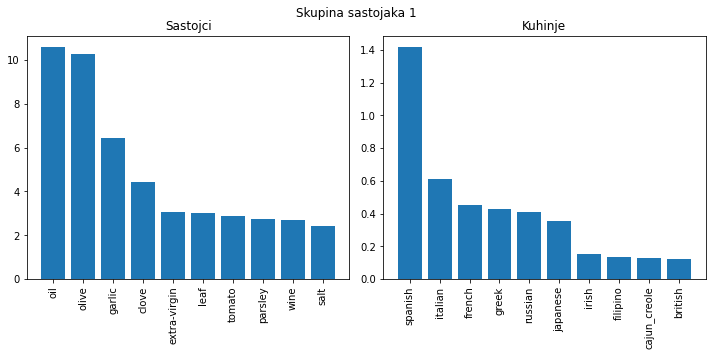

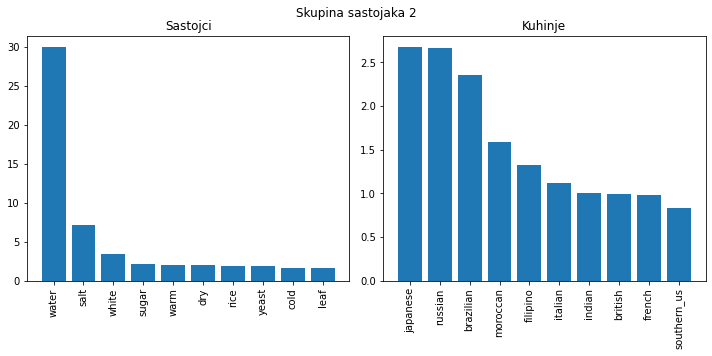

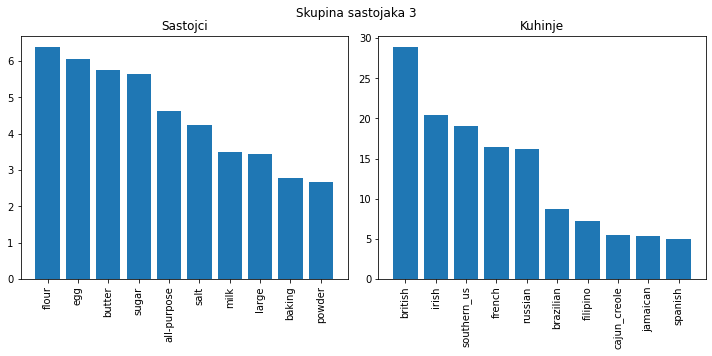

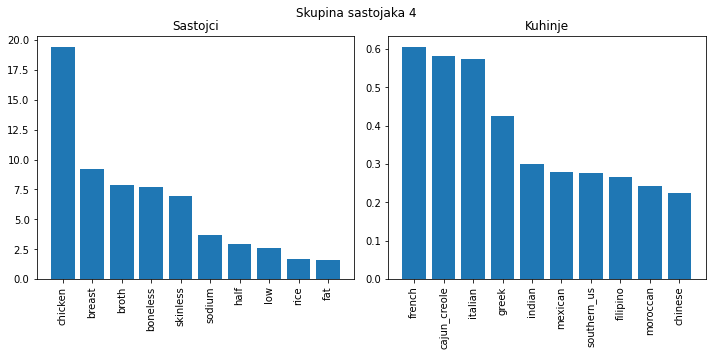

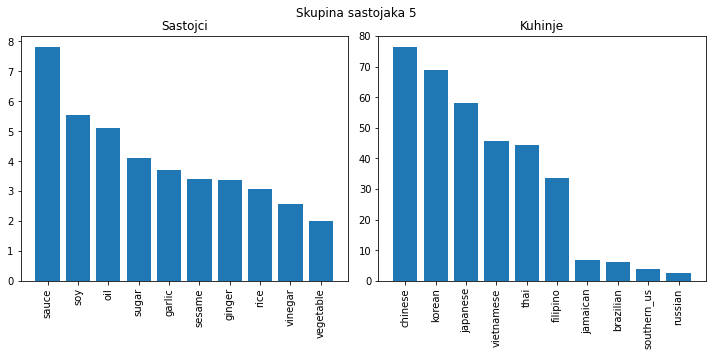

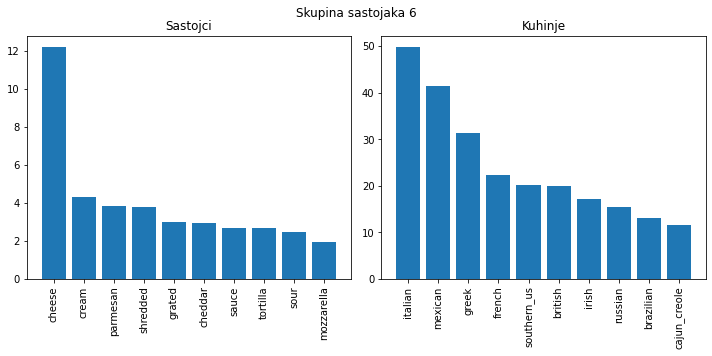

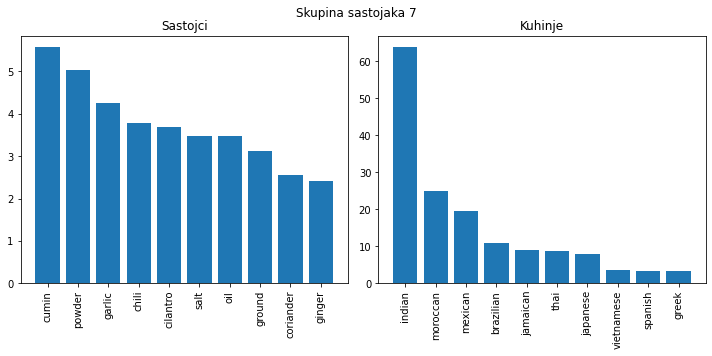

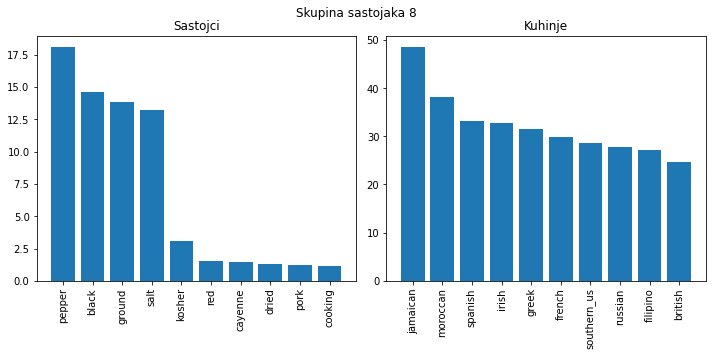

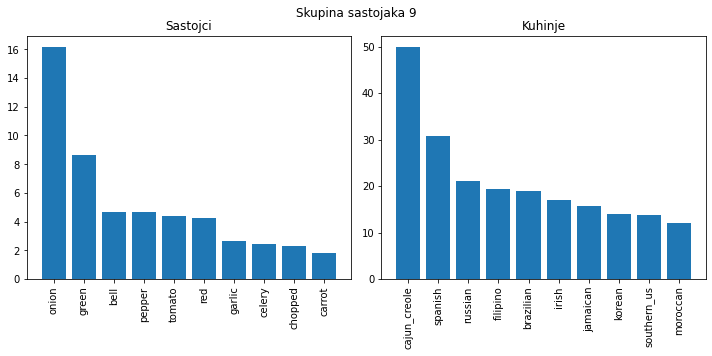

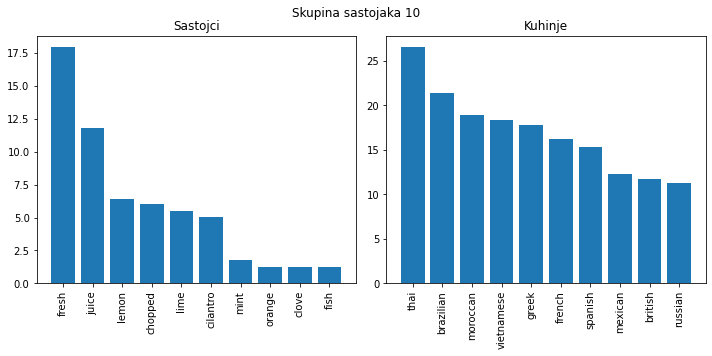

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def prikazi_temu(id_teme):
    popis = []
    zbroj = 0
    for i in range(W.shape[0]):
        zbroj += W[i][id_teme]
    for i in range(W.shape[0]):
        popis.append((W[i][id_teme]/zbroj, indToIngredient[i]))
    popis.sort(reverse=True)
    popis_sastojci = popis
    broj = 10
    popis_drzave = po_temama[id_teme]
    yoni = [[100*x[0] for x in popis_sastojci[:broj]], 
            [100*x[0] for x in popis_drzave[:broj]]]
    xevi = [[x[1] for x in popis_sastojci[:broj]], 
            [x[1] for x in popis_drzave[:broj]]]
    
    data=np.random.random((2,10))
    xaxes = ['Sastojci','Kuhinje']
    yaxes = ['Udio','Udio']
    titles = ['Sastojci','Kuhinje'] 

    f,a = plt.subplots(1,2, figsize=(10,5))
    f.tight_layout()
    a = a.ravel()
    for idx,ax in enumerate(a):
        popis = po_temama[id_teme][:10]
        ax.bar(range(len(yoni[idx])), yoni[idx], align='center')
        ax.set_xticks(range(len(xevi[idx])))
        ax.set_xticklabels(xevi[idx], rotation='vertical', fontsize=10)
        ax.set_title(titles[idx])
        #ax.set_xlabel(xaxes[idx])
        #ax.set_ylabel(yaxes[idx])
        plt.tight_layout()
    f.subplots_adjust(top=0.9)
    f.suptitle('Skupina sastojaka ' + str(id_teme+1))
    plt.show()
for i in range(broj_tema):
    prikazi_temu(i)